## 1 Simple time series
Simple time series example: tracking state with linear dynamics

In [3]:
from pfilter import ParticleFilter, independent_sample, squared_error
from scipy.stats import norm, gamma, uniform 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

Utility function to filter a time series offline and return results:

In [99]:
def apply_filter(pf, ys):
    """Apply filter pf to a series of observations (time_steps, h)  and return a dictionary:
    
        particles: an array of particles (time_steps, n, d)
        weights: an array of weights (time_steps,)
        map_states: an array of MAP states (time_steps, d)
        mean_states: an array of expectations (time_steps, d)
    """

    states = []
    pf.init_filter()  # reset
    for y in ys:
        pf.update(y)
        states.append([pf.original_particles, pf.weights, pf.map_state, pf.mean_state])
    return {
        name: np.array([s[i] for s in states])
        for i, name in enumerate(["particles", "weights", "map_states", "mean_states"])
    }

In [151]:
def plot_particles(x, y, yn, states, transform_fn=None):
    """Plot a 1D tracking result as a line graph with overlaid
    scatterplot of particles. Particles are sized according to
    normalised weight at each step.
    
        x: time values
        y: original (uncorrupted) values
        yn: noisy (observed) values
        states: dictionary return from apply_pfilter
        transform_fn: function to apply to state space before plotting (optional)
    """
    fig, ax = plt.subplots()
    ax.plot(x, y, label='True', lw=1)
    ax.plot(x, yn, label='Noisy', lw=2)
    
    means = states["mean_states"]
    particles = states["particles"]
    ws = states["weights"]
    
    if transform_fn:
        means = transform_fn(x, means)
        particles = transform_fn(x, particles)        
    
    plt.plot(x, means[:,0], 'C4', label='Mean est.', lw=4)
    plt.scatter(np.tile(x, (len(particles[0]),1)).ravel(), particles[:,:,0].T, s=ws*ws*10000/np.sqrt(len(ws)), alpha=0.25, label='Particles')

    ax.legend()
    
def filter_plot(x, y, yn, pf, transform_fn=None):
    """Apply a filter to yn, and plot the results using plot_particles()"""
    states = apply_filter(pf, yn)
    plot_particles(x, y, yn, states, transform_fn)


## (a) Tracking a 1D sinewave

### Data
We generate a noisy (co)sine wave with a linear trend, and Gaussian noise added:

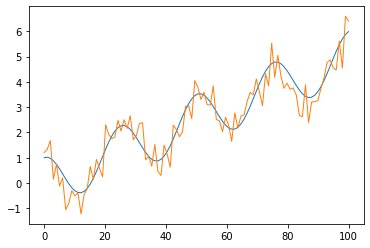

In [178]:
# Noisy sine wave data
x = np.linspace(0, 100, 100)
y = np.cos(x/4.0) + 0.05 * x
yn = y + np.random.normal(0,0.5,x.shape)


fig, ax = plt.subplots()
ax.plot(x, y, label='True', lw=1)
ax.plot(x, yn, label='Noisy', lw=1)

### Purely stochastic dynamics (random walk)

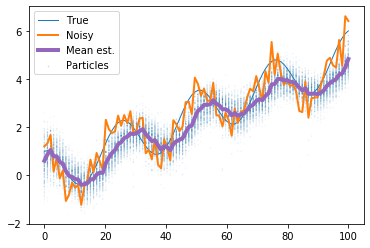

In [179]:
# No dynamics
# just diffusion on x
prior_fn = lambda n: np.random.normal(0,1,(n,1))
dt = 0.05
noise = 0.15
sigma = 1.0

pf = ParticleFilter(prior_fn = prior_fn, 
                    observe_fn = lambda x:  x,  
                    dynamics_fn=lambda x:   x ,
                    n_particles=250, 
                    noise_fn = lambda x: x + np.random.normal(0, noise, x.shape),
                    weight_fn = lambda x,y : squared_error(x, y, sigma=sigma),
                    resample_proportion=0.01)

filter_plot(x, y, yn, pf)

### Simple linear dynamics

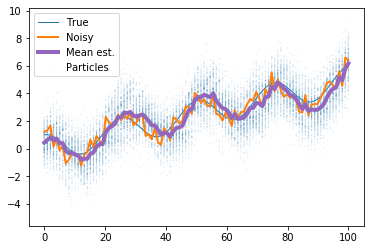

In [182]:
# Linear dynamics
# x, dx, ddx
prior_fn = lambda n: np.random.normal(0,1,(n,3))
dt = 0.25
noise = 0.125
sigma = 2.0

# linear dynamics
D = np.array([[1, dt, 0.5*dt**2],
               [0, 1, dt],
               [0, 0, 1]])

O = np.array([[1, 0, 0]])
pf = ParticleFilter(prior_fn = prior_fn, 
                    observe_fn = lambda x:  x @ O.T,  
                    dynamics_fn=lambda x:   x @ D.T ,
                    n_particles=200, 
                    noise_fn = lambda x: x + np.random.normal(0, noise, x.shape),
                    weight_fn = lambda x,y : squared_error(x, y, sigma=sigma),
                    resample_proportion=0.02)

filter_plot(x, y, yn, pf)


### Linear dynamics with missing values

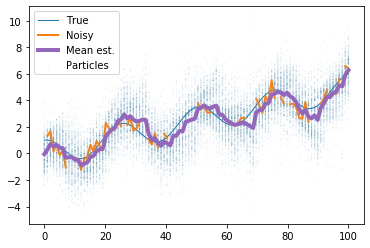

In [185]:
# Missing values; randomly delete 25% of the observations
y_missing = np.array([yt if np.random.uniform()>0.25 else None for yt in yn])
filter_plot(x, y, y_missing, pf)


### Latent variable estimation (cosine model)

(100, 4) (100, 200, 4)


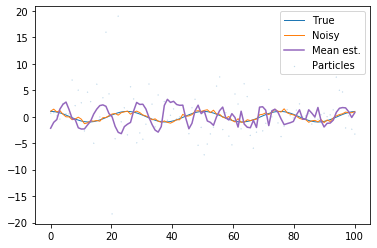

In [492]:
# Cosine estimation
# x = a cos(wt + p)
# t a w p

prior_fn = lambda n: np.random.uniform(0,1,(n,4)) * [0.0, 5.0, 1.0, np.pi*2.0]
dt = 0.1
noise = 2.0
sigma = 100.0

# need to have time as an input
y_with_t = np.stack([x, yn]).T

def cos_observe(x):    
    return x[:,1] * np.cos(x[:,0] * x[:,2] + x[:,3])


pf = ParticleFilter(prior_fn = prior_fn, 
                    observe_fn = cos_observe,  
                    dynamics_fn = lambda x:x ,
                    n_particles=200, 
                    noise_fn = lambda x: x + np.random.normal(0, noise, x.shape) * [0.0, 1.0, 0.05, 1.0],
                    weight_fn = lambda x,y : squared_error(x, y, sigma=sigma),
                    resample_proportion=0.05)

states = apply_filter(pf, yn)
plot_particles(x, y, states, transform_fn = lambda t, x: (x[...,1] * np.cos((t * x[...,2].T).T + x[...,3]))[:,None])
